In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Set random seed
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Data preprocessing
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [06:25<00:00, 442kB/s]  


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training samples: 50000
Test samples: 10000


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Feature extraction
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
        )

        # Classification head
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # Feature extraction
        x = self.conv_block(x)
        
        # Flatten the output for the fully connected layers
        x = self.flatten(x)
        
        # Fully connected layers
        x = self.dropout(x)
        # You can also try without dropout or after fc1 or both for comparison
        x = self.fc1(x)
        # x = self.dropout(x)  # You can also try different rate of dropout
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [7]:
# Initialize model
model = CNN().to(device)
print(model)

CNN(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 545,098
Trainable parameters: 545,098


In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(trainloader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [10]:
# Training loop
print("\nStarting training...")
num_epochs = 10
train_losses, train_accs = [], []
test_losses, test_accs = [], []

start_time = time.time()

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, testloader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f} seconds')


Starting training...

Epoch 1/10
--------------------------------------------------
Batch 0/391, Loss: 2.3073, Acc: 12.50%
Batch 100/391, Loss: 1.5313, Acc: 39.16%
Batch 200/391, Loss: 1.1963, Acc: 44.70%
Batch 300/391, Loss: 1.1789, Acc: 48.45%
Train Loss: 1.3737, Train Acc: 50.94%
Test Loss: 1.1382, Test Acc: 59.78%

Epoch 2/10
--------------------------------------------------
Batch 0/391, Loss: 1.0774, Acc: 60.94%
Batch 100/391, Loss: 1.1406, Acc: 62.82%
Batch 200/391, Loss: 1.0797, Acc: 63.35%
Batch 300/391, Loss: 0.9313, Acc: 64.16%
Train Loss: 1.0062, Train Acc: 64.58%
Test Loss: 0.9534, Test Acc: 65.93%

Epoch 3/10
--------------------------------------------------
Batch 0/391, Loss: 0.9025, Acc: 70.31%
Batch 100/391, Loss: 0.9585, Acc: 69.37%
Batch 200/391, Loss: 0.8576, Acc: 69.25%
Batch 300/391, Loss: 0.7181, Acc: 69.18%
Train Loss: 0.8697, Train Acc: 69.35%
Test Loss: 0.8590, Test Acc: 70.13%

Epoch 4/10
--------------------------------------------------
Batch 0/391, Loss:

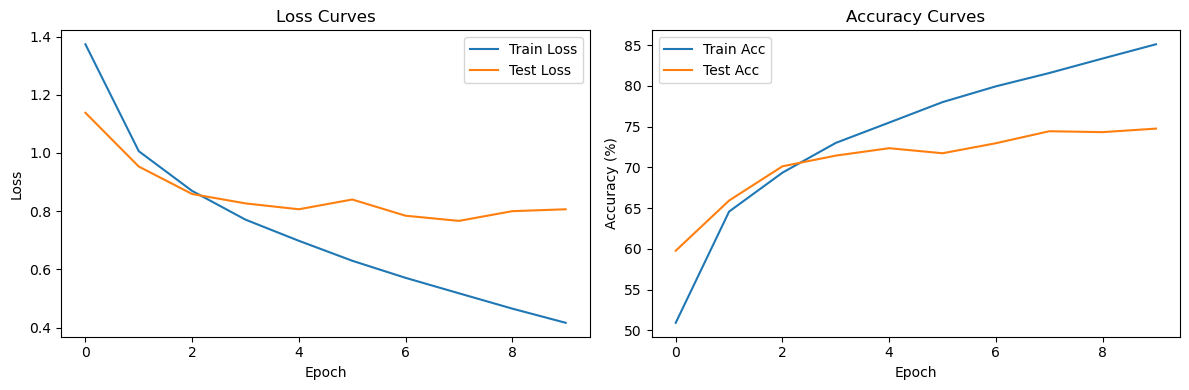

In [11]:
# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Final results summary
print(f"\n" + "="*60)
print("CIFAR-10 Basic CNN Results Summary")
print("="*60)
print(f"Final Train Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")
print(f"Total Parameters: {total_params:,}")
print(f"Total Epochs: {num_epochs}")
print(f"Training Time: {total_time:.2f} seconds")


CIFAR-10 Basic CNN Results Summary
Final Train Accuracy: 85.09%
Final Test Accuracy: 74.75%
Total Parameters: 545,098
Total Epochs: 10
Training Time: 185.73 seconds


In [14]:
# Per-class accuracy
model.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        c = (predicted == target).squeeze()
        for i in range(target.size(0)):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nPer-class Test Accuracy:")
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'{classes[i]}: {acc:.2f}%')


Per-class accuracy analysis...

Per-class Test Accuracy:
plane: 80.70%
car: 83.90%
bird: 68.20%
cat: 49.50%
deer: 63.50%
dog: 65.70%
frog: 85.30%
horse: 79.70%
ship: 86.20%
truck: 84.80%


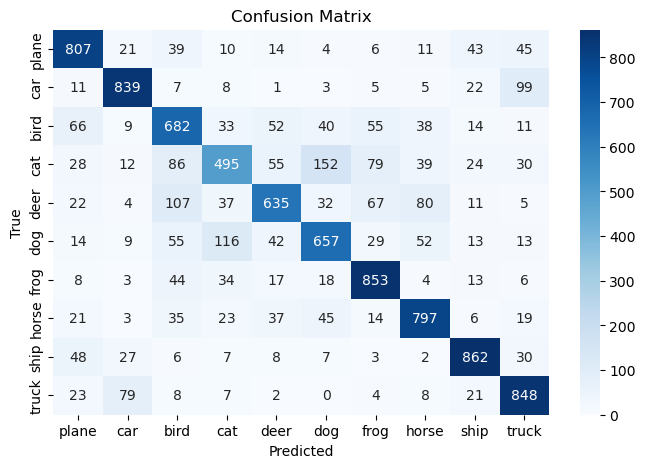

In [18]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = []
y_true = []
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(target.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()